In [49]:
! which python3
! python3 -V

/Users/nick/Dev/magisterka/venv/bin/python3
Python 3.9.6


In [50]:
import typing as t
import jax.numpy as jnp
import pandas as pd
import metadata
import haiku as hk
import utils
import jax
import optax
import random

from jax.config import config
config.update("jax_debug_nans", True)

### Statics

In [51]:
BLOCK_SIZE = int(2*24*60/5) # 2 days
BATCH_SIZE = 8
SPLIT = 0.85
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3
SEED = 2137
NUM_TRAINING_STEPS = 300
EVAL_INTERVAL = 10

### Load data

In [52]:
class DataLoader:
    def __init__(self, data_path: str):
        self.df = pd.read_pickle(data_path)

        _map = metadata.NODE_IDS_TO_LABELS_MAPPING
        self.edges_to_samples_mapping = {}

        for x, row in enumerate(metadata.ADJACENCY_MATRIX):
            for y, _ in enumerate(row):

                if metadata.ADJACENCY_MATRIX[x][y]:
                    self.edges_to_samples_mapping[(_map[x], _map[y])] = \
                        self.get_data_for_link(_map[x], _map[y])

        _b = BLOCK_SIZE*BATCH_SIZE
        # all the sample array are equal size, so it doesn't matter which one we choose
        num_subsets = (self.edges_to_samples_mapping[('uci', 'ftj')].shape[0] - 1) // _b
        cutoff_num = (self.edges_to_samples_mapping[('uci', 'ftj')].shape[0] - 1) % _b
        split_idx = int(SPLIT * num_subsets)

        #  encode the data
        self.edges_to_samples_mapping = {
            k: self.encode(samples)
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  input/target split
        self.edges_to_samples_mapping = {
            k: {'input': samples[:-1], 'target': samples[1:]}
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  rounding to batchable size & pre-batching
        self.edges_to_samples_mapping = {
            k: {
                'input': jnp.reshape(samples['input'][:-cutoff_num], (num_subsets, BATCH_SIZE, BLOCK_SIZE, 1)),
                'target': jnp.reshape(samples['target'][:-cutoff_num], (num_subsets, BATCH_SIZE, BLOCK_SIZE, 1))
            } for k, samples in self.edges_to_samples_mapping.items()
        }

        #  batching
        self.edges_to_samples_mapping = {
            k: [
                {
                    'input': samples['input'][idx], 'target': samples['target'][idx]
                } for idx in range(samples['input'].shape[0])
            ] for k, samples in self.edges_to_samples_mapping.items()
        }

        self.train_ds = {
            k: samples[:split_idx] for k, samples in self.edges_to_samples_mapping.items()
        }
        self.test_ds = {
            k: samples[split_idx:] for k, samples in self.edges_to_samples_mapping.items()
        }

    class DataIter:
        def __init__(self, data):
            self.edge_data = data

        def __iter__(self):
            pass

        def __next__(self):
            return random.choice(self.edge_data)

    def get_edge_data_iterator(self, src: str, dst: str, train=True):
        if train:
            data = self.train_ds[(src, dst)]
        else:
            data = self.test_ds[(src, dst)]
        return self.DataIter(data)

    @staticmethod
    def encode(arr: jnp.array):
        return jnp.log(arr)

    def get_data_for_link(self, src: str, dst: str) -> jnp.array:
        ss: pd.Series = self.df[(self.df["src_host"] == src) & (self.df["dst_host"] == dst)]
        return ss.incoming_rate_avg.to_numpy(dtype=jnp.uint32)

### Model

In [53]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    tokens: jnp.ndarray
    state: t.Any
    rng_key: jnp.ndarray

Batch = t.Mapping[str, jnp.ndarray]

In [54]:
dl = DataLoader("../data/samples_5m_subset_v1.pkl")
train_di = dl.get_edge_data_iterator('uci', 'ftj', train=True)
test_di = dl.get_edge_data_iterator('uci', 'ftj', train=False)
expl_batch = next(train_di)

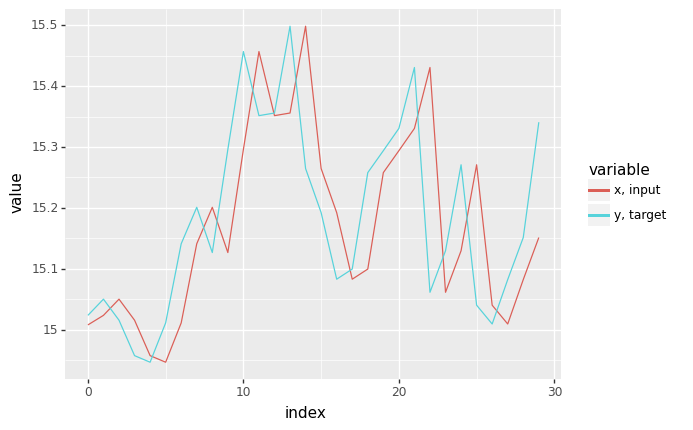

In [55]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][0, :_off], 
    prediction=expl_batch['input'][0, :_off],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

In [56]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.GRU(HIDDEN_SIZE)
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

def sequence_loss(batch: Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    batch_size, sequence_length, _ = batch['input'].shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    _input = batch['input']  # (B, T, 1)

    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)  # (B, T, HIDDEN_SIZE)

    logits_batched = hk.BatchApply(hk.Linear(1))(logits)  # (B, T, 1)

    loss = jnp.mean(jnp.abs(batch['target'] - logits_batched))  # MAE
    return loss

@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

def generate(context: jnp.ndarray, seq_len: int) -> jnp.array:
    """Draws samples from the model, given an initial context."""
    core = make_network()
    dense = hk.Linear(1)

    batch_size, sequence_length, _ = context.shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    # _input = jnp.expand_dims(context, -1)  # (B, T, 1)
    _input = jnp.reshape(context, (BLOCK_SIZE, 1, 1))

    context_outs, state = hk.dynamic_unroll(core, _input, initial_state)
    context_outs = hk.BatchApply(dense)(context_outs)

    # Now, unroll one step at a time using the running recurrent state.
    _outs = []
    logits = context_outs[-1]
    for _ in range(seq_len - sequence_length):
        logits, state = core(logits, state)
        logits = dense(logits)
        _outs.append(logits)

    return jnp.concatenate([context_outs, jnp.stack(_outs)])

In [57]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
loss_fn = jax.jit(loss_fn)
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [58]:
def train(state):
    train_loss_all = jnp.array([])
    eval_loss_all = jnp.array([])

    for step in range(NUM_TRAINING_STEPS):
        train_batch = next(train_di)
        state = update(state, train_batch)

        if step % EVAL_INTERVAL == 0:
            eval_batch = next(train_di)
            train_loss = loss_fn(state.params, train_batch)
            eval_loss = loss_fn(state.params, eval_batch)
            train_loss_all = jnp.append(train_loss_all, train_loss)
            eval_loss_all = jnp.append(eval_loss_all, eval_loss)
            print({
                'step': step,
                'train_loss': float(train_loss),
                'eval_loss': float(eval_loss),
            })

    return state, train_loss_all, eval_loss_all

final_state, train_loss_arr, eval_loss_arr = train(state)

{'step': 0, 'train_loss': 14.49959659576416, 'eval_loss': 14.49107837677002}
{'step': 10, 'train_loss': 12.209168434143066, 'eval_loss': 12.195058822631836}
{'step': 20, 'train_loss': 9.844195365905762, 'eval_loss': 10.062082290649414}
{'step': 30, 'train_loss': 7.566812515258789, 'eval_loss': 7.690873146057129}
{'step': 40, 'train_loss': 5.054045677185059, 'eval_loss': 5.054045677185059}
{'step': 50, 'train_loss': 2.743415117263794, 'eval_loss': 2.7199172973632812}
{'step': 60, 'train_loss': 0.5156173706054688, 'eval_loss': 0.5960066318511963}
{'step': 70, 'train_loss': 0.9816187620162964, 'eval_loss': 0.7867773771286011}
{'step': 80, 'train_loss': 0.4954017996788025, 'eval_loss': 0.4987475574016571}
{'step': 90, 'train_loss': 0.5064635276794434, 'eval_loss': 0.5713270306587219}
{'step': 100, 'train_loss': 0.5263497233390808, 'eval_loss': 0.5151141285896301}
{'step': 110, 'train_loss': 0.49945223331451416, 'eval_loss': 0.4464271366596222}
{'step': 120, 'train_loss': 0.5461374521255493

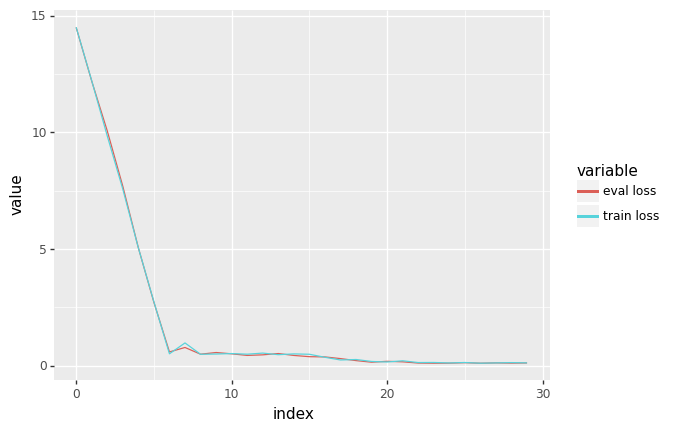

In [59]:
plot = utils.plot_samples(
    truth=train_loss_arr,
    prediction=eval_loss_arr,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [60]:
predict = hk.transform(generate)
predict = jax.jit(predict.apply, static_argnums=3)

In [61]:
val_batch = next(test_di)
context = val_batch["input"][:1, :]
predicted = predict(final_state.params, None, context, BLOCK_SIZE*2 )

In [62]:
predicted.shape, val_batch["target"].shape

((1152, 1, 1), (8, 576, 1))

In [63]:
print(f" MAE: {jnp.mean(jnp.abs(val_batch['target'][0, :, -1] - predicted[:BLOCK_SIZE, -1, -1])):.4f}")
print(f" MSE: {jnp.mean(jnp.square(val_batch['target'][0, :, -1] - predicted[:BLOCK_SIZE, -1, -1])):.4f}")

 MAE: 0.1076
 MSE: 0.0799


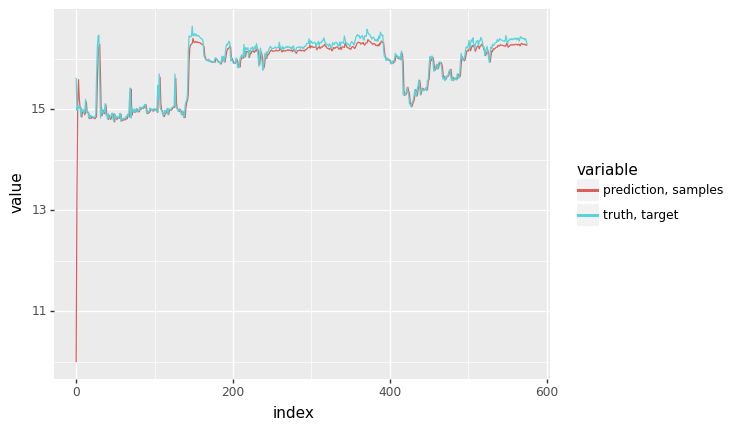

In [64]:
plot = utils.plot_samples(
    val_batch["target"][0, :, -1],
    predicted[:BLOCK_SIZE, -1, -1],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()